## Library Importation

In [ ]:
import pubchempy as pcp
from IPython.display import display, Math, HTML, Markdown
import numpy as np
import scipy.linalg as la
import math
from statistics import mean, median, mode, stdev
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import sympy 
from itertools import combinations
from collections import defaultdict, Counter
from networkx.algorithms.dominating import is_dominating_set

## Graph Initialization

## Graph Extraction under PubChem database

### Individual Fetcher 

In [79]:
class MolecularGraphExtractor:
    def __init__(self, compound_name, relabel=True, visualize=True):
        self.compound_name = compound_name
        self.relabel = relabel
        self.visualize = visualize

        self.smiles = None
        self.graph = None
        self.mol = None

        try:
            self.smiles = self._get_smiles_from_pubchem()
            self.graph, self.mol = self._smiles_to_nx_graph()

            if self.relabel:
                self.graph = self._relabel_graph()

            if self.visualize:
                self.show_views()

        except Exception as e:
            print(f"[Error] {compound_name}: {e}")
            self.graph = None
            self.mol = None

    def _get_smiles_from_pubchem(self):
        comps = pcp.get_compounds(self.compound_name, namespace="name")
        if not comps:
            raise ValueError(f"No compound found for '{self.compound_name}'")

        c = comps[0]
        smiles = c.canonical_smiles or c.isomeric_smiles

        if not smiles and c.inchi:
            mol = Chem.MolFromInchi(c.inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)

        if not smiles:
            raise ValueError("No SMILES available.")

        return smiles

    def _smiles_to_nx_graph(self):
        mol = Chem.MolFromSmiles(self.smiles)
        if mol is None:
            raise ValueError("RDKit could not parse SMILES.")

        AllChem.Compute2DCoords(mol)
        G = nx.Graph()

        for atom in mol.GetAtoms():
            idx = atom.GetIdx()
            symbol = atom.GetSymbol()
            if symbol != "H":  
                pos = mol.GetConformer().GetAtomPosition(idx)
                G.add_node(idx, element=symbol, pos=(pos.x, pos.y))

        for bond in mol.GetBonds():
            a1, a2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            if mol.GetAtomWithIdx(a1).GetSymbol() != "H" and mol.GetAtomWithIdx(a2).GetSymbol() != "H":
                order = int(bond.GetBondTypeAsDouble())
                G.add_edge(a1, a2, order=order)

        return G, mol

    def _relabel_graph(self):
        mapping = {old: new for new, old in enumerate(sorted(self.graph.nodes()))}
        return nx.relabel_nodes(self.graph, mapping, copy=True)

    def show_views(self):
        """Visualize molecule with RDKit + NetworkX in Jupyter."""
        if self.graph is None or self.mol is None:
            print("Visualization unavailable.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # RDKit drawing
        try:
            img = Draw.MolToImage(self.mol, size=(300, 300), kekulize=True)
            axes[0].imshow(img)
            axes[0].set_title(self.compound_name)
            axes[0].axis("off")
        except Exception as e:
            axes[0].text(0.5, 0.5, f"RDKit draw failed:\n{e}", ha="center", va="center")
            axes[0].axis("off")

        try:
            pos = nx.get_node_attributes(self.graph, "pos")
            if not pos:
                pos = nx.spring_layout(self.graph)

            labels = {n: n for n in self.graph.nodes()}
            widths = [1.5 + (d.get("order", 1) - 1) for _, _, d in self.graph.edges(data=True)]

            nx.draw(
                self.graph,
                pos,
                labels=labels,
                node_color="green",
                node_size=250,
                edge_color="black",
                width=widths,
                font_size=7,
                ax=axes[1],
            )
            axes[1].set_title("Index View")
            axes[1].axis("off")
        except Exception as e:
            axes[1].text(0.5, 0.5, f"NetworkX draw failed:\n{e}", ha="center", va="center")
            axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    def get_graph(self):
        return self.graph

    def get_smiles(self):
        return self.smiles

    def get_molecule(self):
        return self.mol

    def get_adjacency_matrix(self):
        if self.graph:
            return nx.adjacency_matrix(self.graph).toarray()
        return None

    def get_node_features(self):
        if self.graph:
            return {node: data for node, data in self.graph.nodes(data=True)}
        return None

### Batch Fetcher

In [80]:
class MolecularGraphExtractorBatch:
    def __init__(self, compound_string, relabel=True, visualize=True):
        self.compounds = [name.strip() for name in compound_string.split(",")]
        self.relabel = relabel
        self.visualize = visualize
        self.results = {}
        self._process_all()

    def _process_all(self):
        for name in self.compounds:
            extractor = MolecularGraphExtractor(name, relabel=self.relabel, visualize=False)
            self.results[name] = extractor

    def display_all(self):
        for name, extractor in self.results.items():
            display(Markdown(f"## 🧪 {name}"))
            if extractor.get_molecule() is None:
                display(Markdown("**❌ Error: Molecule fetch failed.**"))
            else:
                extractor.visualize = True
                extractor.show_views()

    def get(self, name):
        return self.results.get(name)

    def get_all(self):
        return self.results

## 🧪 Kaempferol

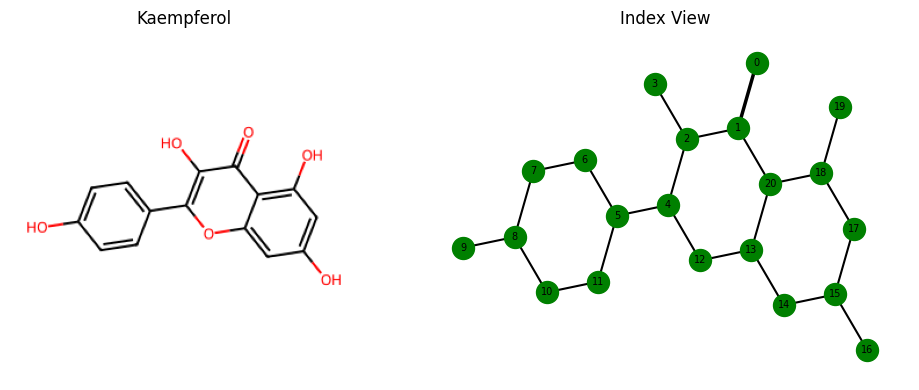

## 🧪 Myricetin

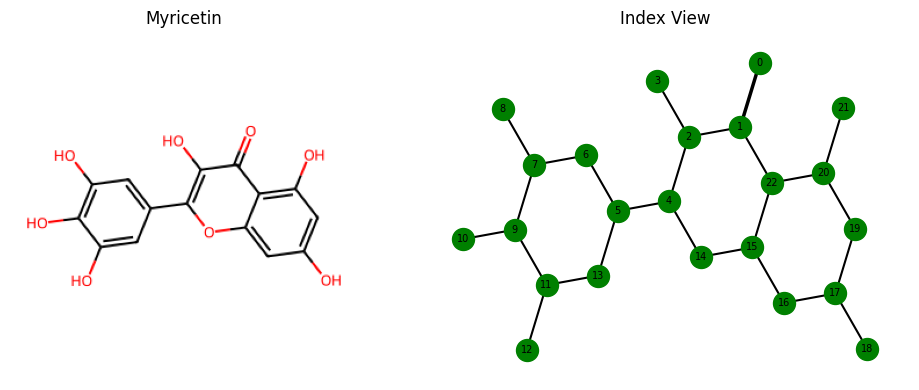

In [81]:
MolecularGraphExtractorBatch("Kaempferol, Myricetin").display_all()

## Graph Details and Computations

### Graph Information

#### Properties Definitions 

In [ ]:
class MolecularGraphSummary:
    def __init__(self, G: nx.Graph, name: str = "Molecule"):
        if not isinstance(G, nx.Graph):
            raise TypeError("Input must be a NetworkX Graph object.")
        self.G = G
        self.name = name
        self.results = self._compute_properties()

    def _compute_properties(self):
        G = self.G
        props = {}

        # Basic properties
        props["nodes"] = G.number_of_nodes()
        props["edges"] = G.number_of_edges()
        props["components"] = nx.number_connected_components(G)
        props["avg_degree"] = mean(dict(G.degree()).values())
        props["density"] = nx.density(G)
        props["max_degree"] = max(dict(G.degree()).values())
        props["min_degree"] = min(dict(G.degree()).values())
        props["degree_sequence"] = sorted(dict(G.degree()).values(), reverse=True)  

        # Clustering
        props["clustering_avg"] = nx.average_clustering(G)
        props["transitivity"] = nx.transitivity(G)

        # Assortativity
        props["assortativity_degree"] = nx.degree_assortativity_coefficient(G)

        # Path-related metrics (only if connected)
        if nx.is_connected(G):
            props["diameter"] = nx.diameter(G)
            props["radius"] = nx.radius(G)
            props["avg_path_length"] = nx.average_shortest_path_length(G)
            props["node_connectivity"] = nx.node_connectivity(G)
            props["edge_connectivity"] = nx.edge_connectivity(G)
        else:
            props["diameter"] = None
            props["radius"] = None
            props["avg_path_length"] = None
            props["node_connectivity"] = None
            props["edge_connectivity"] = None

        # Ring structure
        cycles = nx.cycle_basis(G)
        props["ring_count"] = len(cycles)
        props["girth"] = min((len(c) for c in cycles), default=None)
        props["cyclomatic_number"] = (
            props["edges"] - props["nodes"] + props["components"]
        )

        return props

    def summary(self):
        """Return property dictionary."""
        return self.results

    def display(self, decimals: int = 4):
            """Display the summary as a Markdown table in Jupyter."""
            df = pd.DataFrame([self.results])
            # round float columns for display purposes
            for col, val in df.iloc[0].items():
                if isinstance(val, float):
                    df.at[0, col] = round(val, decimals)
            display(Markdown(f"### 📊 Molecular Graph Summary — **{self.name}**"))
            display(df.T.rename(columns={0: "Value"}).style.hide(axis="index"))

        # fallback text representation
    def __repr__(self):
        return f"<MolecularGraphSummary {self.name}: nodes={self.results['nodes']} edges={self.results['edges']}>"

#### Batch Properties Processing

In [ ]:
class MolecularGraphSummaryBatch:
    def __init__(self, compound_string, metrics_string=None):
        self.compound_names = [name.strip() for name in compound_string.split(",")]
        self.selected_metrics = None
        if metrics_string:
            self.selected_metrics = [m.strip().lower() for m in metrics_string.split(",")]
        self.results = {}
        self._run_batch()

    def _run_batch(self):
        for name in self.compound_names:
            try:
                extractor = MolecularGraphExtractor(name, relabel=True, visualize=False)
                G = extractor.get_graph()
                if G is None:
                    raise ValueError("Graph not available.")
                summary = MolecularGraphSummary(G, name)
                self.results[name] = summary.summary()
            except Exception as e:
                self.results[name] = {"Error": str(e)}

    def __getitem__(self, compound):
        return self.results.get(compound, {})

    def display_all(self, decimals=4):
        for name, props in self.results.items():
            display(Markdown(f"## 📊 Molecular Graph Summary — **{name.title()}**"))

            if "Error" in props:
                display(Markdown(f"**Error:** {props['Error']}"))
                continue

            display_dict = props
            if self.selected_metrics:
                display_dict = {k: v for k, v in props.items() if k.lower() in self.selected_metrics}

            df = pd.DataFrame(display_dict.items(), columns=["Property", "Value"])
            df["Value"] = df["Value"].apply(lambda x: round(x, decimals) if isinstance(x, float) else x)
            display(df.style.hide(axis="index"))
            display(Markdown("---"))

    def __repr__(self):
        names = ", ".join(self.compound_names)
        return f"<MolecularGraphSummaryBatch[{names}]>"
    def __len__(self):
        return len(self.results)


In [ ]:
MolecularGraphSummaryBatch("quercetin, fisetin", "nodes, edges, diameter").display_all()

### Molecular Properties

In [ ]:
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors

class MolecularData:
    """
    Wraps a single compound: pulls PubChem identifiers, then uses your
    MolecularGraphExtractor to get an RDKit Mol and compute missing props.
    """

    def __init__(self, compound_name: str):
        self.name = compound_name
        self.compound = self._get_pubchem_record()
        self.extractor = MolecularGraphExtractor(compound_name,
                                                 relabel=False,
                                                 visualize=False)
        self.mol = self.extractor.get_molecule()
        if self.mol is None:
            raise ValueError("RDKit molecule could not be built.")
        self._build_tables()

    # ---------- helpers ----------
    def _get_pubchem_record(self):
        rec = pcp.get_compounds(self.name, namespace="name")
        if not rec:
            raise ValueError(f"No PubChem entry for '{self.name}'")
        return rec[0]

    def _build_tables(self):
        # --- Basic Identifiers -----------------
        self.df_basic = pd.DataFrame(
            {
                "Property": ["CID", "Formula", "SMILES", "InChIKey"],
                "Value": [
                    self.compound.cid,
                    self.compound.molecular_formula,
                    self.extractor.get_smiles(),          # use fetcher’s SMILES
                    self.compound.inchikey,
                ],
            }
        )

        # --- Molecular Properties --------------
        pub = self.compound  # shorthand
        mol = self.mol
        self.df_molprop = pd.DataFrame(
            [
                ["Molecular Weight", pub.molecular_weight or Descriptors.MolWt(mol)],
                ["Exact Mass", pub.exact_mass or Descriptors.ExactMolWt(mol)],
                ["Heavy Atom Count", pub.heavy_atom_count or rdMolDescriptors.CalcNumHeavyAtoms(mol)],
                ["H‑Bond Donors", rdMolDescriptors.CalcNumHBD(mol)],
                ["H‑Bond Acceptors", rdMolDescriptors.CalcNumHBA(mol)],
                ["Rotatable Bonds", Descriptors.NumRotatableBonds(mol)],
                ["Formal Charge", pub.charge],
                ["Isotope Atom Count", pub.isotope_atom_count],
                ["Covalently Bonded Units", pub.covalent_unit_count],
            ],
            columns=["Property", "Value"],
        )

        # --- Structural Descriptors ------------
        self.df_struct = pd.DataFrame(
            [
                ["TPSA", rdMolDescriptors.CalcTPSA(mol)],
                ["XLogP3", Crippen.MolLogP(mol)],
                ["Complexity", pub.complexity]
            ],
            columns=["Property", "Value"],
        )

    # ---------- display ----------
    def display(self, na_rep="—"):
        display(Markdown(f"## 🧪 {self.name.title()}"))
        for title, df in [
            ("Basic Identifiers", self.df_basic),
            ("Molecular Properties", self.df_molprop),
            ("Structural Descriptors", self.df_struct),
        ]:
            display(Markdown(f"**{title}:**"))
            display(df.style.hide(axis="index").format(na_rep=na_rep))

In [ ]:
class MolecularDataBatch:
    """
    Example
    -------
    batch = MolecularDataBatch("quercetin, fisetin, caffeine")
    batch.display_all()
    """

    def __init__(self, compound_string: str):
        self.names = [n.strip() for n in compound_string.split(",")]
        self.results = {}
        self._run()

    def _run(self):
        for name in self.names:
            try:
                self.results[name] = MolecularData(name)
            except Exception as e:
                self.results[name] = f"Error: {e}"

    # --------- display ----------
    def display_all(self):
        for name, obj in self.results.items():
            if isinstance(obj, str):          # error string
                display(Markdown(f"## ❌ {name.title()}"))
                display(Markdown(f"**Error:** {obj}"))
            else:
                obj.display()

    # quick dict‑like access
    def __getitem__(self, name):
        return self.results.get(name)

    def __repr__(self):
        return f"<MolecularDataBatch[{', '.join(self.names)}]>"

In [ ]:
batch = MolecularDataBatch("quercetin, fisetin")
batch.display_all()

## Graph Polynomials

In [60]:
class GraphPolynomials:
    def __init__(self, G):
        if not isinstance(G, nx.Graph):
            raise TypeError("Graph must be a networkx.Graph")
        self.G = G.copy()
        self.x = sympy.Symbol("x")
        self.y = sympy.Symbol("y")
        self.nodes = list(self.G.nodes)
        self.edges = list(self.G.edges)
        self.n = self.G.number_of_nodes()
        self.m = self.G.number_of_edges()
        self.u = sympy.Symbol("u")
        self.v = sympy.Symbol("v")
        self.p = sympy.Symbol("p")
        self._cache = {}

    def chromatic_polynomial(self):
        def _compute(G):
            x = self.x
            if any(u == v for u, v in G.edges()):
                return 0
            if G.number_of_edges() == 0:
                return x ** G.number_of_nodes()
            u, v = list(G.edges())[0]
            G_del = G.copy()
            G_del.remove_edge(u, v)
            G_con = nx.contracted_nodes(G.copy(), u, v, self_loops=False)
            return _compute(G_del) - _compute(G_con)
        return sympy.simplify(_compute(self.G))

    def m_polynomial(self):
        degree_pairs = defaultdict(int)
        for u, v in self.edges:
            du, dv = self.G.degree[u], self.G.degree[v]
            i, j = sorted((du, dv))
            degree_pairs[(i, j)] += 1
        poly = sum(k * self.x**i * self.y**j for (i, j), k in degree_pairs.items())
        return sympy.simplify(poly)

    def nm_polynomial(self):
        degree_pairs = defaultdict(int)
        for u, v in self.edges:
            du, dv = self.G.degree[u], self.G.degree[v]
            degree_pairs[(du, dv)] += 1 
        poly = sum(k * self.x**i * self.y**j for (i, j), k in degree_pairs.items())
        return sympy.simplify(poly)

    def independence_polynomial(self):
        alpha = len(nx.algorithms.approximation.maximum_independent_set(self.G))
        s_k = [0] * (alpha + 1)
        for k in range(alpha + 1):
            for subset in combinations(self.nodes, k):
                if all(not self.G.has_edge(u, v) for u, v in combinations(subset, 2)):
                    s_k[k] += 1
        poly = sum(s_k[k] * self.x**k for k in range(alpha + 1))
        return sympy.simplify(poly)

    def matching_polynomial(self):
        nu = len(nx.algorithms.maximal_matching(self.G))
        m_k = [0] * (nu + 1)
        for k in range(nu + 1):
            for edge_set in combinations(self.edges, k):
                nodes_used = set()
                if all(u not in nodes_used and v not in nodes_used and not nodes_used.update((u, v)) for u, v in edge_set):
                    m_k[k] += 1
        poly_expr = sum((-1)**k * m_k[k] * self.x**(self.n - 2*k) for k in range(nu + 1))
        return sympy.simplify(poly_expr)

    def domination_polynomial(self):
        counts = {}
        for k in range(1, self.n + 1):
            count = 0
            for subset in combinations(self.nodes, k):
                if is_dominating_set(self.G, subset):
                    count += 1
            if count > 0:
                counts[k] = count
        if not counts:
            return 0
        gamma = min(counts.keys())
        poly = sum(coeff * self.x**k for k, coeff in counts.items() if k >= gamma)
        return sympy.simplify(poly)

    def clique_polynomial(self):
        clique_counts = defaultdict(int)
        for clique in nx.enumerate_all_cliques(self.G):
            k = len(clique)
            if k >= 1:
                clique_counts[k] += 1
        poly = 1 + sum(count * self.x**k for k, count in clique_counts.items())
        return sympy.simplify(poly)

    def vertex_cover_polynomial(self):
        cover_counts = {}
        for k in range(1, self.n + 1):
            count = 0
            for subset in combinations(self.nodes, k):
                covered_edges = set()
                for u, v in self.edges:
                    if u in subset or v in subset:
                        covered_edges.add((u, v))
                if len(covered_edges) == self.m:
                    count += 1
            if count > 0:
                cover_counts[k] = count
        if not cover_counts:
            return 0
        tau = min(cover_counts.keys())
        poly = sum(count * self.x**k for k, count in cover_counts.items() if k >= tau)
        return sympy.simplify(poly)

    def edge_cover_polynomial(self):
        cover_counts = {}
        for k in range(1, self.m + 1):
            count = 0
            for edge_set in combinations(self.edges, k):
                covered_nodes = set()
                for u, v in edge_set:
                    covered_nodes.update([u, v])
                if covered_nodes == set(self.nodes):
                    count += 1
            if count > 0:
                cover_counts[k] = count
        if not cover_counts:
            return 0
        rho = min(cover_counts.keys())
        poly = sum(count * self.x**k for k, count in cover_counts.items() if k >= rho)
        return sympy.simplify(poly)

    def laplacian_polynomial(self):
        L = sympy.Matrix(nx.laplacian_matrix(self.G).toarray())
        return ((self.x * sympy.eye(self.n) - L).det()).expand()

    def adjacency_polynomial(self):
        A = sympy.Matrix(nx.adjacency_matrix(self.G).toarray())
        return ((self.x * sympy.eye(self.n) - A).det()).expand()

    def distance_polynomial(self):
        D = nx.floyd_warshall_numpy(self.G)
        poly = 0
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if D[i, j] < float('inf'):
                    poly += self.x ** int(D[i, j])
        return sympy.simplify(poly)

    def rank_polynomial(self):
        rG = self.n - nx.number_connected_components(self.G)
        poly = 0
        for k in range(self.m + 1):
            for edge_subset in combinations(self.edges, k):
                subG = self.G.edge_subgraph(edge_subset).copy()
                rA = subG.number_of_nodes() - nx.number_connected_components(subG)
                x_term = self.x ** (rG - rA)
                y_term = self.y ** (k - rA)
                poly += x_term * y_term
        return sympy.simplify(poly)

    def tutte_polynomial(self):
        rG = self.n - nx.number_connected_components(self.G)
        T = 0
        for k in range(self.m + 1):
            for edge_subset in combinations(self.edges, k):
                subG = self.G.edge_subgraph(edge_subset).copy()
                rA = subG.number_of_nodes() - nx.number_connected_components(subG)
                x_term = (self.x - 1) ** (rG - rA)
                y_term = (self.y - 1) ** (k - rA)
                T += x_term * y_term
        return sympy.simplify(T)

    def reliability_polynomial(self):
        T = self.tutte_polynomial()
        R = (self.p ** (self.n - 1)) * T.subs({self.x: 1, self.y: 1 / self.p})
        return sympy.simplify(R)

    def dichromatic_polynomial(self):
        poly = 0
        for k in range(self.m + 1):
            for edge_subset in combinations(self.edges, k):
                subG = self.G.edge_subgraph(edge_subset).copy()
                num_components = nx.number_connected_components(subG)
                exponent = k - self.n + num_components
                poly += (self.u ** num_components) * (self.v ** exponent)
        return sympy.simplify(poly)

    # On-demand access + caching
    _poly_map = {
        "chromatic": "chromatic_polynomial",
        "m": "m_polynomial",
        "nm": "nm_polynomial",
        "independence": "independence_polynomial",
        "matching": "matching_polynomial",
        "domination": "domination_polynomial",
        "clique": "clique_polynomial",
        "vertex_cover": "vertex_cover_polynomial",
        "edge_cover": "edge_cover_polynomial",
        "laplacian": "laplacian_polynomial",
        "adjacency": "adjacency_polynomial",
        "distance": "distance_polynomial",
        "rank": "rank_polynomial",
        "tutte": "tutte_polynomial",
        "reliability": "reliability_polynomial",
        "dichromatic": "dichromatic_polynomial"
    }

    def get(self, name):
        name = name.lower()
        if name in self._cache:
            return self._cache[name]
        if name not in self._poly_map:
            raise KeyError(f"Unknown polynomial: {name}")
        method = getattr(self, self._poly_map[name])
        result = method()
        self._cache[name] = result
        return result

    def __getattr__(self, name):
        if name in self._poly_map:
            return self.get(name)
        raise AttributeError(f"'GraphPolynomials' object has no attribute '{name}'")

## Batch polynomial generation

In [61]:
from IPython.display import display, Math
from sympy import latex

class GraphPolynomialsBatch:
    def __init__(self, compound_string, polynomial_string):
        """
        Initialize with a string of comma-separated compound names and polynomials.

        Example:
            GraphPolynomialsBatch("glucose, fructose", "tutte, chromatic")
        """
        self.compound_names = [name.strip() for name in compound_string.split(",")]
        self.polynomials = [p.strip().lower() for p in polynomial_string.split(",")]
        self.results = {}

        self._run_batch()

    def _run_batch(self):
        for name in self.compound_names:
            try:
                extractor = MolecularGraphExtractor(name, visualize=True)
                G = extractor.get_graph()
                gp = GraphPolynomials(G)

                self.results[name] = {}

                for poly_name in self.polynomials:
                    try:
                        value = gp.get(poly_name)
                        self.results[name][poly_name] = value
                    except Exception as e:
                        self.results[name][poly_name] = f"Error: {e}"

            except Exception as e:
                self.results[name] = {p: f"Error: {e}" for p in self.polynomials}

    def get(self, compound, polynomial):
        """Access a specific polynomial value by compound and polynomial name."""
        return self.results.get(compound, {}).get(polynomial, None)

    def __getitem__(self, compound):
        """Access all polynomial results for a single compound."""
        return self.results.get(compound, {})

    def display_all_latex(self):
        for compound, polys in self.results.items():
            display(Markdown(f"### 🔬 Compound: **{compound.capitalize()}**"))
            for pname, val in polys.items():
                display(Markdown(f"**Polynomial**: `{pname}`"))
                if isinstance(val, sympy.Expr):
                    display(Math(rf"{pname}(x, y) = {latex(val)}"))
                else:
                    display(Markdown(f"`{pname}`: {val}"))
            display(Markdown("---"))

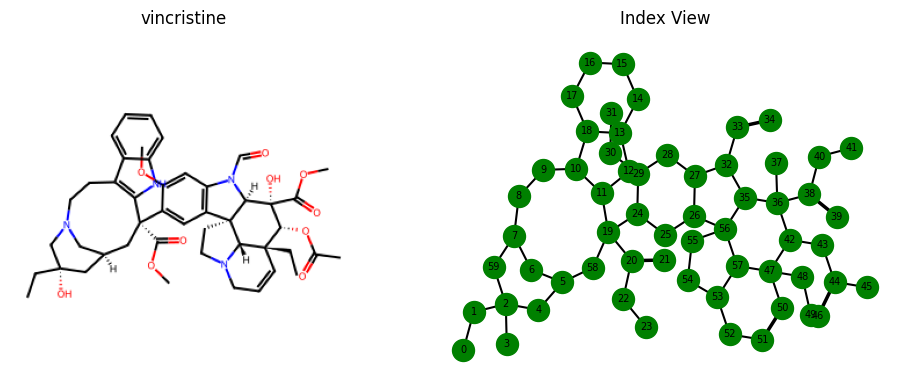

### 🔬 Compound: **Vincristine**

**Polynomial**: `nm`

<IPython.core.display.Math object>

**Polynomial**: `distance`

<IPython.core.display.Math object>

**Polynomial**: `m`

<IPython.core.display.Math object>

---

In [62]:
GraphPolynomialsBatch("vincristine", "nm, distance, m").display_all_latex()

## Graph Polynomials Batch Plot

In [77]:
import sympy as sp
import ast
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

class GraphPolynomialsBatchPlot:
    def __init__(self, compound_string, polynomial_string, bounds_string):
        self.compounds = [s.strip() for s in compound_string.split(",")]
        self.polynomials = [s.strip().lower() for s in polynomial_string.split(",")]

        try:
            self.x_bounds, self.y_bounds = eval("[" + bounds_string + "]")
        except Exception as e:
            raise ValueError(f"Invalid bounds string: {bounds_string}\n{e}")

        self.x_vals = np.linspace(self.x_bounds[0], self.x_bounds[1], 100)
        self.y_vals = np.linspace(self.y_bounds[0], self.y_bounds[1], 100)

        self._xy_polys = {"m", "nm", "rank", "tutte", "reliability", "dichromatic"}
        self._x_only = {"chromatic", "independence", "matching", "domination", 
                        "clique", "vertex_cover", "edge_cover", "laplacian", 
                        "adjacency", "distance"}

    def _evaluate_2d(self, poly):
        x = sp.Symbol("x")
        f = sp.lambdify(x, poly, "numpy")
        X = self.x_vals
        Y = f(X)
        return X, Y

    def _evaluate_3d(self, poly):
        x, y = sp.symbols("x y")
        f = sp.lambdify((x, y), poly, "numpy")
        X, Y = np.meshgrid(self.x_vals, self.y_vals)
        Z = f(X, Y)
        return X, Y, Z

    def show(self):
        for compound in self.compounds:
            display(Markdown(f"## 🔬 Compound: **{compound.capitalize()}**"))
            try:
                extractor = MolecularGraphExtractor(compound, relabel=True, visualize=False)
                G = extractor.get_graph()
                gp = GraphPolynomials(G)

                num_polys = len(self.polynomials)
                fig = plt.figure(figsize=(6 * num_polys, 6))

                for idx, pname in enumerate(self.polynomials):
                    ax_type = "2d" if pname in self._x_only else "3d"
                    try:
                        poly = gp.get(pname)

                        if ax_type == "2d":
                            ax = fig.add_subplot(1, num_polys, idx + 1)
                            x_vals, y_vals = self._evaluate_2d(poly)
                            ax.plot(x_vals, y_vals, label=pname, color="blue", linewidth=2)
                            ax.set_title(f"{pname}(x)")
                            ax.set_xlabel("x")
                            ax.set_ylabel(f"{pname}(x)")
                            ax.grid(True)

                        else:
                            ax = fig.add_subplot(1, num_polys, idx + 1, projection="3d")
                            X, Y, Z = self._evaluate_3d(poly)
                            ax.plot_surface(X, Y, Z, alpha=0.7, cmap="plasma", edgecolor='k', linewidth=0.2)
                            ax.set_title(f"{pname}(x, y)")
                            ax.set_xlabel("x")
                            ax.set_ylabel("y")
                            ax.set_zlabel("Value")

                    except Exception as e:
                        display(Markdown(f"⚠️ Error plotting `{pname}`: `{e}`"))
                        continue

                plt.tight_layout()
                plt.show()

            except Exception as e:
                display(Markdown(f"❌ Error processing compound `{compound}`: `{e}`"))

## 🔬 Compound: **Caffeine**

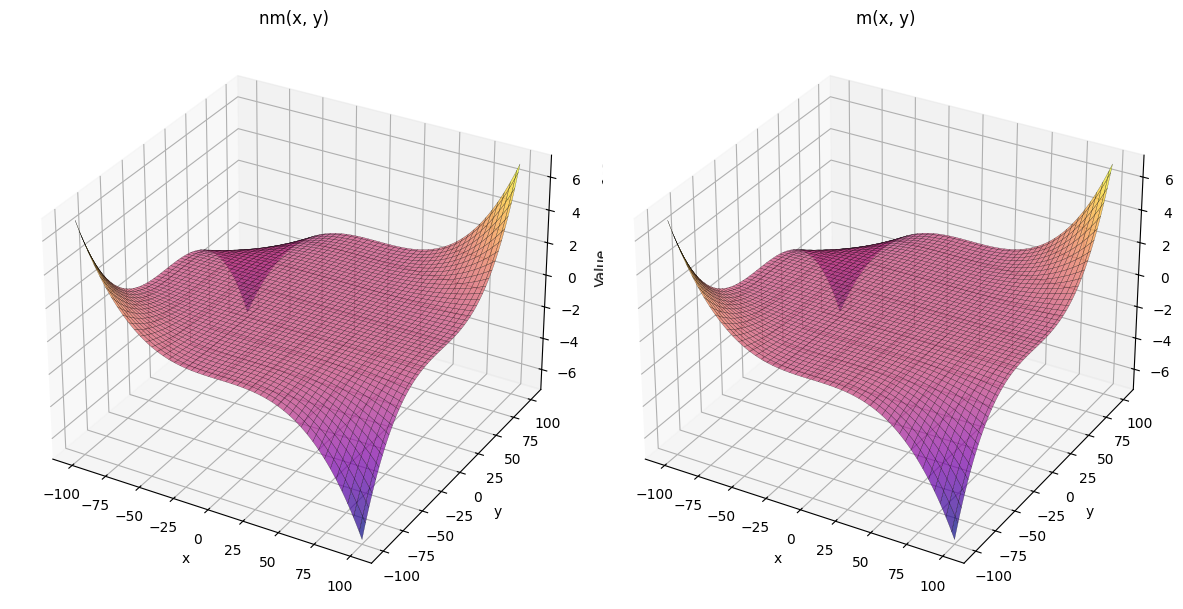

In [83]:
GraphPolynomialsBatchPlot(" caffeine", "nm, m", "(-100, 100), (-100, 100)").show()

### Graph Matrices

In [ ]:
class GraphMatrices:
    def __init__(self, G):
        if not isinstance(G, (nx.Graph, nx.MultiGraph)):
            raise TypeError("Graph must be a networkx.Graph or MultiGraph.")
        self.G = G
        self._cache = {}

    def adjacency_matrix(self):
        return nx.adjacency_matrix(self.G).toarray()

    def incidence_matrix(self, oriented=False):
        return nx.incidence_matrix(self.G, oriented=oriented).toarray()

    def laplacian_matrix(self):
        return nx.laplacian_matrix(self.G).toarray()

    def distance_matrix(self):
        return nx.floyd_warshall_numpy(self.G)

    def resistance_distance_matrix(self):
        return nx.resistance_distance(self.G)

    def reciprocal_laplacian_matrix(self):
        L = self.laplacian_matrix()
        D_inv = np.diag(1 / np.sqrt(np.diag(L)))
        return D_inv @ L @ D_inv

    def normalized_laplacian_matrix(self):
        return nx.normalized_laplacian_matrix(self.G).toarray()

    class SpectralProperties:
        def __init__(self, matrix, symbolic=False):
            self.matrix = matrix
            self.symbolic = symbolic
            if symbolic:
                self.sympy_matrix = sympy.Matrix(matrix)
                self.eigenvalues = self.sympy_matrix.eigenvals()
            else:
                if np.allclose(matrix, matrix.T, atol=1e-10):
                    self.eigenvalues = la.eigh(matrix, eigvals_only=True)
                else:
                    self.eigenvalues = la.eigvals(matrix)

        def spectrum(self):
            return self.eigenvalues

        def spectral_radius(self):
            return (max(abs(ev) for ev in self.eigenvalues.keys())
                    if self.symbolic else np.max(np.abs(self.eigenvalues)))

        def energy(self):
            return (sum(abs(ev) * mult for ev, mult in self.eigenvalues.items())
                    if self.symbolic else np.sum(np.abs(self.eigenvalues)))

        def incidence_energy(self):
            if self.symbolic:
                raise NotImplementedError("SVD not supported symbolically.")
            sigma = la.svd(self.matrix, compute_uv=False)
            return np.sum(sigma)

        def spectral_moments(self, k):
            return (sum(ev**k * mult for ev, mult in self.eigenvalues.items()) /
                    self.sympy_matrix.shape[0] if self.symbolic
                    else np.mean(self.eigenvalues**k))

        def estrada_index(self):
            return (sum(sympy.exp(ev) * mult for ev, mult in self.eigenvalues.items())
                    if self.symbolic else np.sum(np.exp(self.eigenvalues)))

    # ---------- on‑demand access & caching ----------
    _matrix_map = {
        "adjacency":           "adjacency_matrix",
        "incidence":           "incidence_matrix",
        "laplacian":           "laplacian_matrix",
        "distance":            "distance_matrix",
        "resistance_distance": "resistance_distance_matrix",
        "reciprocal_laplacian":"reciprocal_laplacian_matrix",
        "normalized_laplacian":"normalized_laplacian_matrix",
    }

    def get(self, name, **kwargs):
        """
        Get (and cache) a matrix by name.
        Extra kwargs (e.g. oriented=True) are forwarded to the underlying
        matrix builder when first computed.
        """
        name = name.lower()
        if name not in self._matrix_map:
            raise KeyError(f"Unknown matrix '{name}'. "
                           f"Choices: {list(self._matrix_map)}")
        if name not in self._cache:
            builder = getattr(self, self._matrix_map[name])
            self._cache[name] = builder(**kwargs) if kwargs else builder()
        return self._cache[name]

    def spectra(self, name, symbolic=False, **kwargs):
        """
        Return a SpectralProperties object for a chosen matrix.
        """
        cache_key = (name, "sym" if symbolic else "num")
        if cache_key not in self._cache:
            M = self.get(name, **kwargs)
            self._cache[cache_key] = self.SpectralProperties(M, symbolic=symbolic)
        return self._cache[cache_key]

    # ---------- pretty / LaTeX helpers ----------
    def pretty_matrix(self, name, **kwargs):
        M = sympy.Matrix(self.get(name, **kwargs))
        print(sympy.pretty(M))

    def latex_matrix(self, name, **kwargs):
        from IPython.display import display, Math
        M = sympy.Matrix(self.get(name, **kwargs))
        display(Math(rf"{name} = {sympy.latex(M)}"))

    # ---------- attribute sugar ----------
    def __getattr__(self, name):
        if name in self._matrix_map:
            return self.get(name)
        raise AttributeError(name)
    def analyze_matrix_latex(self, name, symbolic=False, moment_orders=(1, 2, 3)):
        from IPython.display import display, Math

        name_title = name.replace("_", " ").title()
        matrix = self.get(name)
        M_sym = sympy.Matrix(matrix)

        # Display matrix itself
        display(Math(rf"\textbf{{{name_title} Matrix}}: \quad {sympy.latex(M_sym)}"))

        # Compute spectral properties
        spec = self.spectra(name, symbolic=symbolic)

        # Eigenvalues
        display(Math(r"\textbf{Spectral Properties}"))
        if symbolic:
            lines = [rf"\lambda = {sympy.latex(ev)} \quad (\times {mult})"
                    for ev, mult in spec.eigenvalues.items()]
            display(Math(r"\\".join(lines)))
        else:
            eigen_latex = r",\; ".join([f"{ev:.4f}" for ev in sorted(spec.eigenvalues)])
            display(Math(rf"\lambda = \left[ {eigen_latex} \right]"))

        # Scalar invariants
        display(Math(rf"\rho = {spec.spectral_radius():.6f} \quad "
                    rf"E = {spec.energy():.6f} \quad "
                    rf"I_E = {spec.estrada_index():.6f}"))

        # Incidence energy (if applicable)
        if name.lower() == "incidence" and not symbolic:
            display(Math(rf"I_{{\mathrm{{inc}}}} = {spec.incidence_energy():.6f}"))

        # Spectral moments
        for k in moment_orders:
            μ = spec.spectral_moments(k)
            if symbolic:
                display(Math(rf"\mu_{{{k}}} = {sympy.latex(μ)}"))
            else:
                display(Math(rf"\mu_{{{k}}} = {μ:.6f}"))

In [ ]:
class GraphSpectrumBatch:
    def __init__(self, compound_str, config_str):
        self.compound_names = [c.strip() for c in compound_str.split(",")]
        self.config = self._parse_config(config_str)
        self.results = {}

        for compound in self.compound_names:
            try:
                G = MolecularGraphExtractor(compound, visualize=False).get_graph()
                gm = GraphMatrices(G)
                self.results[compound] = {}

                for matrix_type, metrics in self.config.items():
                    matrix = gm.get(matrix_type)
                    spec = gm.spectra(matrix_type)

                    self.results[compound][matrix_type] = {
                        "matrix": matrix,
                        "spectrum": spec,
                        "metrics": {}
                    }

                    for metric in metrics:
                        if metric == "spectrum":
                            self.results[compound][matrix_type]["metrics"]["spectrum"] = spec.spectrum()
                        elif metric == "estrada":
                            self.results[compound][matrix_type]["metrics"]["estrada"] = spec.estrada_index()
                        elif metric == "energy":
                            self.results[compound][matrix_type]["metrics"]["energy"] = spec.energy()
                        elif metric == "radius":
                            self.results[compound][matrix_type]["metrics"]["radius"] = spec.spectral_radius()
                        elif metric.startswith("moment"):
                            try:
                                k = int(metric.split(":")[1])
                                μ = spec.spectral_moments(k)
                                self.results[compound][matrix_type]["metrics"][f"moment_{k}"] = μ
                            except:
                                print(f"Invalid moment format: {metric}")
                        elif metric == "incidence_energy":
                            try:
                                val = spec.incidence_energy()
                                self.results[compound][matrix_type]["metrics"]["incidence_energy"] = val
                            except NotImplementedError:
                                self.results[compound][matrix_type]["metrics"]["incidence_energy"] = "Not supported"
                        else:
                            self.results[compound][matrix_type]["metrics"][metric] = "Unknown metric"

            except Exception as e:
                print(f"Failed to process {compound}: {e}")
                self.results[compound] = None

    def _parse_config(self, config_str):
        config = {}
        entries = [e.strip() for e in config_str.split(",")]
        for entry in entries:
            if ";" not in entry:
                continue
            mat_type, metric = [s.strip().lower() for s in entry.split(";")]
            if mat_type not in config:
                config[mat_type] = []
            config[mat_type].append(metric)
        return config
    
    def display_all_latex(self):
        for compound, mat_data in self.results.items():
            if mat_data is None:
                continue

            # Section title for the compound
            display(Markdown(f"### 🔬 Compound: **{compound.title()}**"))

            for mat_type, data in mat_data.items():
                spec = data["spectrum"]
                metrics = data["metrics"]
                title = mat_type.title().replace("_", " ")

                # Matrix title
                display(Markdown(f"**Matrix Type**: `{title}`"))

                for metric_name, value in metrics.items():
                    if metric_name == "spectrum":
                        if isinstance(value, dict):  # symbolic
                            vals = [f"{latex(ev)}" for ev in value.keys()]
                        else:
                            vals = [f"{ev:.4f}" for ev in sorted(value)]
                        joined = r",\; ".join(vals)
                        display(Math(rf"\text{{Spec}}({mat_type}) = \left[ {joined} \right]"))

                    elif metric_name.startswith("moment_"):
                        k = metric_name.split("_")[1]
                        display(Math(rf"\mu_{{{k}}} = {value:.6f}"))

                    elif isinstance(value, str):
                        display(Markdown(f"- **{metric_name}**: `{value}`"))

                    else:
                        display(Math(rf"\text{{{metric_name}}} = {value:.6f}"))

                display(Markdown("---"))

In [ ]:
GraphSpectrumBatch("fructose", "adjacency; estrada, incidence; estrada").display_all_latex()

## Graph Partition 

In [ ]:
class GraphPartition:
    def __init__(self, G):
        if not isinstance(G, (nx.Graph, nx.MultiGraph)):
            raise TypeError("Graph must be a networkx.Graph or MultiGraph.")
        self.G = G.copy()
        self.nodes = list(G.nodes)
        self.edges = list(G.edges)
        self.degree_dict = dict(G.degree())

    def _show_dataframe(self, df, show):
        if show:
            display(df.style.hide(axis='index'))
            return None
        return df

    def degree_partition(self, show=True):
        degree_counts = Counter(self.degree_dict.values())
        df = pd.DataFrame(sorted(degree_counts.items()), columns=["Degree", "Count"])
        return self._show_dataframe(df, show)

    def distance_partition(self, show=True):
        lengths = dict(nx.floyd_warshall(self.G))
        dist_counter = defaultdict(int)
        for i, u in enumerate(self.nodes):
            for v in self.nodes[i + 1:]:
                d = lengths[u][v]
                if d != float('inf'):
                    dist_counter[d] += 1
        df = pd.DataFrame(sorted(dist_counter.items()), columns=["Distance", "Count"])
        return self._show_dataframe(df, show)

    def degree_pair_partition(self, show=True):
        degree_pairs = defaultdict(int)
        for u, v in self.edges:
            du, dv = self.degree_dict[u], self.degree_dict[v]
            i, j = sorted((du, dv))
            degree_pairs[(i, j)] += 1
        df = pd.DataFrame(
            sorted(((i, j, c) for (i, j), c in degree_pairs.items())),
            columns=["deg(u)", "deg(v)", "Count"]
        )
        return self._show_dataframe(df, show)

    def szeged_partition(self, show=True):
        lengths = dict(nx.all_pairs_shortest_path_length(self.G))
        pair_counts = defaultdict(int)

        for u, v in self.edges:
            nu = nv = 0
            for w in self.nodes:
                if lengths[w][u] < lengths[w][v]:
                    nu += 1
                elif lengths[w][v] < lengths[w][u]:
                    nv += 1
            pair_counts[(nu, nv)] += 1

        df = pd.DataFrame(
            sorted(((nu, nv, c, nu * nv * c) for (nu, nv), c in pair_counts.items())),
            columns=["n_u", "n_v", "Count", "Total Contribution"]
        )
        return self._show_dataframe(df, show)

    def eccentricity_partition(self, show=True):
        ecc = nx.eccentricity(self.G)
        ecc_counts = Counter(ecc.values())
        df = pd.DataFrame(sorted(ecc_counts.items()), columns=["Eccentricity", "Count"])
        return self._show_dataframe(df, show)

In [ ]:
class GraphPartitionBatch:
    _PARTITION_MAP = {
        "degree":       "degree_partition",
        "distance":     "distance_partition",
        "degree_pair":  "degree_pair_partition",
        "szeged":       "szeged_partition",
        "eccentricity": "eccentricity_partition"
    }

    def __init__(self, compound_str, partition_str):
        self.compound_names = [name.strip() for name in compound_str.split(",")]
        self.partition_names = [p.strip().lower() for p in partition_str.split(",")]
        self.results = {}

        for compound in self.compound_names:
            try:
                G = MolecularGraphExtractor(compound, visualize=False).get_graph()
                gp = GraphPartition(G)
                self.results[compound] = {}

                for pname in self.partition_names:
                    if pname not in self._PARTITION_MAP:
                        self.results[compound][pname] = f"Unknown partition '{pname}'"
                        continue
                    method = getattr(gp, self._PARTITION_MAP[pname])
                    self.results[compound][pname] = method(show=False)
            except Exception as e:
                self.results[compound] = f"Error: {e}"

    def display_all_latex(self):
        for compound, partitions in self.results.items():
            if isinstance(partitions, str):
                display(Markdown(f"### {compound.title()} – *{partitions}*"))
                continue

            display(Markdown(f"## **{compound.title()}**"))
            for pname, result in partitions.items():
                display(Markdown(f"### Partition: `{pname}`"))
                if isinstance(result, str):
                    display(Markdown(f"*{result}*"))
                else:
                    display(result.style.hide(axis='index'))

In [ ]:
GraphPartitionBatch("benzene", "degree, eccentricity").display_all_latex()